GPU memory growth set to True for 1 GPUs
Num GPUs Available:  1
GPU /physical_device:GPU:0 will be used
Using GPU for training
Starting training...
Updating agent at step 1000
Updating agent at step 2000
Episode 10/750, Avg Reward: -1123.68
Updating agent at step 3000
Updating agent at step 4000
Episode 20/750, Avg Reward: -1242.71
Updating agent at step 5000
Updating agent at step 6000
Episode 30/750, Avg Reward: -1127.27
Updating agent at step 7000
Updating agent at step 8000
Episode 40/750, Avg Reward: -1234.14
Updating agent at step 9000
Updating agent at step 10000
Episode 50/750, Avg Reward: -1094.35
Updating agent at step 11000
Updating agent at step 12000
Episode 60/750, Avg Reward: -1262.12
Updating agent at step 13000
Updating agent at step 14000
Episode 70/750, Avg Reward: -1274.22
Updating agent at step 15000
Updating agent at step 16000
Episode 80/750, Avg Reward: -1303.80
Updating agent at step 17000
Updating agent at step 18000
Episode 90/750, Avg Reward: -1086.94
Updati

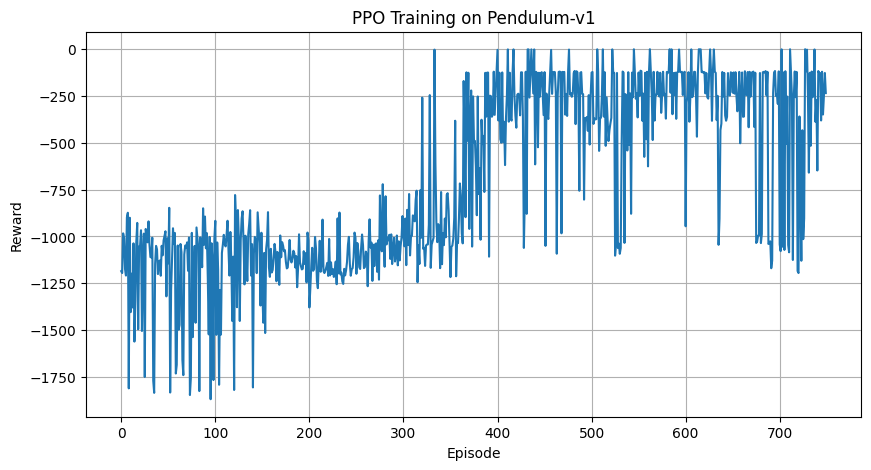

In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU memory growth set to True for {len(gpus)} GPUs")
    except RuntimeError as e:
        print(f"Memory growth must be set before GPUs have been initialized: {e}")

import numpy as np
import tensorflow as tf
import gymnasium as gym
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import datetime

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU {gpus[0].name} will be used")
except Exception as e:
    print(f"GPU error: {e}")
    print("Continuing without GPU memory growth configuration")


np.random.seed(42)
tf.random.set_seed(42)

class PPOAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        action_bound,
        lr_actor=0.0005,
        lr_critic=0.002,
        gamma=0.99,
        lam=0.95,
        clip_ratio=0.1,
        value_coef=0.5,
        entropy_coef=0.02,
        epochs=10,
        batch_size=64
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.gamma = gamma
        self.lam = lam
        self.clip_ratio = clip_ratio
        self.epochs = epochs
        self.batch_size = batch_size
        self.value_coef = value_coef
        self.entropy_coef = entropy_coef

        self.actor = self._build_actor()
        self.critic = self._build_critic()
        self.actor_optimizer = Adam(learning_rate=lr_actor)
        self.critic_optimizer = Adam(learning_rate=lr_critic)

        self.log_std = tf.Variable(-0.5 * np.ones(action_dim, dtype=np.float32))

    def _build_actor(self):
        inputs = Input(shape=(self.state_dim,))
        x = Dense(512, activation='relu')(inputs)
        x = Dense(256, activation='relu')(x)
        x = Dense(128, activation='relu')(x)
        outputs = Dense(self.action_dim, activation='tanh')(x)
        outputs = outputs * self.action_bound
        return Model(inputs, outputs, name='actor')

    def _build_critic(self):
        inputs = Input(shape=(self.state_dim,))
        x = Dense(256, activation='relu')(inputs)
        x = Dense(256, activation='relu')(x)
        outputs = Dense(1, activation=None)(x)
        return Model(inputs, outputs, name='critic')

    def get_action(self, state, deterministic=False):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        mu = self.actor(state)[0]

        if deterministic:
            return mu.numpy()

        std = tf.exp(self.log_std)
        pi = mu + tf.random.normal(shape=mu.shape) * std
        pi = tf.clip_by_value(pi, -self.action_bound, self.action_bound)

        return pi.numpy()

    def get_log_prob(self, states, actions):
        mu = self.actor(states)
        std = tf.exp(self.log_std)

        logp = -0.5 * (((actions - mu) / std) ** 2 + 2 * tf.math.log(std) + np.log(2 * np.pi))
        return tf.reduce_sum(logp, axis=1)

    def get_value(self, state):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        return self.critic(state)[0, 0].numpy()

    @tf.function
    def _actor_train_step(self, states, actions, advantages, old_log_probs):
        with tf.GradientTape() as tape:
            curr_log_probs = self.get_log_prob(states, actions)

            ratio = tf.exp(curr_log_probs - old_log_probs)

            std = tf.exp(self.log_std)
            entropy = tf.reduce_mean(0.5 * (tf.math.log(2.0 * np.pi * std**2) + 1.0))

            clip_adv = tf.clip_by_value(ratio, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio) * advantages
            actor_loss = -tf.reduce_mean(tf.minimum(ratio * advantages, clip_adv))
            actor_loss = actor_loss - self.entropy_coef * entropy

        actor_gradients = tape.gradient(actor_loss, self.actor.trainable_variables + [self.log_std])
        self.actor_optimizer.apply_gradients(zip(actor_gradients, self.actor.trainable_variables + [self.log_std]))

        return actor_loss, entropy

    @tf.function
    def _critic_train_step(self, states, returns):
        with tf.GradientTape() as tape:
            values = self.critic(states)
            values_squeezed = tf.cast(tf.squeeze(values), dtype=returns.dtype)
            critic_loss = tf.reduce_mean((returns - values_squeezed) ** 2) * self.value_coef

        critic_gradients = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_gradients, self.critic.trainable_variables))

        return critic_loss

    def update(self, buffer):
        states = tf.convert_to_tensor(buffer.states, dtype=tf.float32)
        actions = tf.convert_to_tensor(buffer.actions, dtype=tf.float32)
        rewards = np.array(buffer.rewards)
        next_states = tf.convert_to_tensor(buffer.next_states, dtype=tf.float32)
        dones = np.array(buffer.dones)

        values = self.critic(states).numpy().flatten()
        next_values = self.critic(next_states).numpy().flatten()
        advantages = np.zeros_like(rewards)
        returns = np.zeros_like(rewards)
        gae = 0

        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_value = next_values[t]
            else:
                next_value = values[t + 1]

            delta = rewards[t] + self.gamma * next_value * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * self.lam * (1 - dones[t]) * gae
            advantages[t] = gae

        returns = advantages + values
        advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)
        advantages = tf.convert_to_tensor(advantages, dtype=tf.float32)
        returns = tf.convert_to_tensor(returns, dtype=tf.float32)

        old_log_probs = self.get_log_prob(states, actions)

        dataset = tf.data.Dataset.from_tensor_slices(
            (states, actions, advantages, returns, old_log_probs)
        ).shuffle(buffer_size=len(rewards)).batch(self.batch_size)

        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

        for _ in range(self.epochs):
            for batch in dataset:
                state_batch, action_batch, advantage_batch, return_batch, old_log_prob_batch = batch

                self._actor_train_step(state_batch, action_batch, advantage_batch, old_log_prob_batch)
                self._critic_train_step(state_batch, return_batch)

class Buffer:
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []

    def add(self, state, action, reward, next_state, done):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.dones.append(done)

    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []

def train_ppo(env_name="Pendulum-v1", max_episodes=100, update_interval=1000):

    env = gym.make(env_name)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    action_bound = env.action_space.high[0]

    agent = PPOAgent(state_dim, action_dim, action_bound)
    buffer = Buffer()

    total_steps = 0
    episode_rewards = []

    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = 'logs/ppo_pendulum/' + current_time
    summary_writer = tf.summary.create_file_writer(log_dir)

    print("Starting training...")
    for episode in range(max_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:

            action = agent.get_action(state)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            buffer.add(state, action, reward, next_state, done)
            episode_reward += reward
            state = next_state
            total_steps += 1

            if total_steps % update_interval == 0:
                print(f"Updating agent at step {total_steps}")
                agent.update(buffer)
                buffer.clear()

        episode_rewards.append(episode_reward)

        with summary_writer.as_default():
            tf.summary.scalar('episode_reward', episode_reward, step=episode)
            if episode_rewards and episode % 10 == 0:
                tf.summary.scalar('avg_reward_last_10', np.mean(episode_rewards[-10:]), step=episode)

        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            print(f"Episode {episode + 1}/{max_episodes}, Avg Reward: {avg_reward:.2f}")

    if buffer.states:
        agent.update(buffer)

    eval_reward = evaluate_agent(env, agent, episodes=5)
    print(f"Evaluation Reward: {eval_reward:.2f}")

    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards)
    plt.title('PPO Training on Pendulum-v1')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.savefig('ppo_pendulum_rewards.png')

    return agent, episode_rewards

def evaluate_agent(env, agent, episodes=5):
    eval_rewards = []

    for _ in range(episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.get_action(state, deterministic=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state

        eval_rewards.append(episode_reward)

    return np.mean(eval_rewards)

if __name__ == "__main__":
    try:
        with tf.device('/device:GPU:0'):
            print("Using GPU for training")
            agent, rewards = train_ppo(max_episodes=750)
    except Exception as e:
        print(f"Failed to use GPU: {e}")
        print("Falling back to CPU")
        agent, rewards = train_ppo(max_episodes=700)
    agent.actor.save_weights("ppo_pendulum_actor.weights.h5")
    agent.critic.save_weights("ppo_pendulum_critic.weights.h5")